# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.
#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

#Imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from tensorflow.keras import layers
from IPython.display import clear_output
import scipy as scp
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from keras import backend

2023-11-22 08:34:26.006606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-22 08:34:26.069089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 08:34:26.374059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-22 08:34:26.375048: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 08:34:27.949101: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def blur_data(a, blurFactor):
    aBlur = np.zeros(shape=(a.shape[0],a.shape[1],a.shape[2],a.shape[3]))
    for i in range(0, a.shape[0]):
        aBlur[i] = scp.ndimage.gaussian_filter(a[i], blurFactor, 0);

    return aBlur


In [3]:
def rotate_data(a, rotateAngle):
    aRotate = np.zeros(shape=(a.shape[0],a.shape[1],a.shape[2],a.shape[3]))
    for i in range(0, a.shape[0]):
        aRotate[i] = scp.ndimage.rotate(a[i], rotateAngle, reshape=False, mode='grid-constant')

    return aRotate

In [4]:
#Load in data and create the dataloader

#Output for classification is [benign, malignant, normal]

benignDataI = np.load("medicalimaging/dataset/benign/input.npy")
benignDataO = np.load("medicalimaging/dataset/benign/target.npy")

malignantDataI = np.load("medicalimaging/dataset/malignant/input.npy")
malignantDataO = np.load("medicalimaging/dataset/malignant/target.npy")

normalDataI = np.load("medicalimaging/dataset/normal/input.npy")
normalDataO = np.load("medicalimaging/dataset/normal/target.npy")



In [5]:
contrast = 1.2
dInputsClass = np.concatenate((benignDataI, malignantDataI, normalDataI,
                               tf.image.adjust_contrast(benignDataI, contrast), tf.image.adjust_contrast(malignantDataI, contrast), tf.image.adjust_contrast(normalDataI, contrast),
                               blur_data(benignDataI, 0.3), blur_data(malignantDataI, 0.3), blur_data(normalDataI, 0.3),
                               blur_data(benignDataI, 0.4), blur_data(malignantDataI, 0.4), blur_data(normalDataI, 0.4)), axis = 0)

benignLabels = np.zeros((benignDataI.shape[0], 3))
benignLabels[:, 0] = 1

malignantLabels = np.zeros((malignantDataI.shape[0], 3))
malignantLabels[:, 1] = 1

normalLabels = np.zeros((normalDataI.shape[0], 3))
normalLabels[:, 2] = 1

dOutputsClass = np.concatenate((benignLabels, malignantLabels, normalLabels,
                                benignLabels, malignantLabels, normalLabels,
                                benignLabels, malignantLabels, normalLabels,
                                benignLabels, malignantLabels, normalLabels), axis=0)

In [ ]:
dInputsSeg = np.concatenate((benignDataI, malignantDataI, normalDataI,
                             benignDataI, malignantDataI, normalDataI,
                             tf.image.rot90(benignDataI, -1), tf.image.rot90(malignantDataI, -1), tf.image.rot90(normalDataI, -1),
                             blur_data(benignDataI, 0.3), blur_data(malignantDataI, 0.3), blur_data(normalDataI, 0.3)),axis=0)

dOutputsSeg = np.concatenate((benignDataO, malignantDataO, normalDataO,
                             benignDataO, malignantDataO, normalDataO,
                             tf.image.rot90(benignDataO, -1), tf.image.rot90(malignantDataO, -1), tf.image.rot90(normalDataO, -1),
                             blur_data(benignDataO, 0.3), blur_data(malignantDataO, 0.3), blur_data(normalDataO, 0.3)), axis = 0)

del benignDataI
del malignantDataI
del normalDataI
del benignDataO
del malignantDataO
del normalDataO


In [6]:
xTrain, xTest, yTrain, yTest = train_test_split(dInputsClass, dOutputsClass, test_size=0.3)

print(xTrain.shape)

(1962, 128, 128, 3)


In [7]:
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();


class PlotSegLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('binaryIOU'))
        self.val_acc.append(logs.get('val_binaryIOU'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();



# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")


@keras.saving.register_keras_serializable(package="AOAF")
class AOAF(tf.keras.layers.Layer):
    def __init__(self, beta=0.17, alpha_initializer="zeros"):
        super(AOAF, self).__init__()
        self.beta_param = beta
        self.alpha_initializer = keras.initializers.get(alpha_initializer)

    def build(self, input_shape):
        self.alpha = self.add_weight(
            shape=(1,),
            name="alpha",
            initializer=self.alpha_initializer,
            trainable=True
        )

    def call(self, inputs):
        return tf.maximum(0., (inputs - (self.beta_param * self.alpha))) + self.beta_param*self.alpha

    def get_config(self):
        config = {
            "alpha_initializer": keras.initializers.serialize(self.alpha_initializer),
            "beta": self.beta_param
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
# 2nd Try at classification


EPOCHS = 600
BATCH_SIZE = 20

preprocessing = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(0.08, 0.08, fill_mode='nearest'),
    layers.RandomRotation(factor=(-0.2, 0.3))
])


inputs = keras.layers.Input(shape=(128, 128, 3))
x = keras.layers.Conv2D(1, 1, padding='same', activation='linear', kernel_initializer='he_normal')(inputs)
x = keras.layers.Resizing(100, 100, interpolation='lanczos3')(x)
x = preprocessing(x)

x = keras.layers.Conv2D(filters=9, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=9, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=18, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=18, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(84, activation='relu')(x)
x = keras.layers.Dense(36, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.ceil(xTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = lr_schedule)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Display a summary.
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 1)       4         
                                                                 
 resizing (Resizing)         (None, 100, 100, 1)       0         
                                                                 
 sequential (Sequential)     (None, 100, 100, 1)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 9)       90        
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 9)       738       
                                                                 
 batch_normalization (Batch  (None, 100, 100, 9)       36    

In [ ]:
#3rd try using AOAF activation AOAF(x, beta, alpha) = max(0, x-beta*alpha) + beta*alpha


def AOAF(x):
    return tf.math.add(tf.maximum(0., tf.math.subtract(x,0.17*1)), 0.17*1)


EPOCHS = 300
BATCH_SIZE = 20

preprocessing = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(0.08, 0.08, fill_mode='nearest'),
    layers.RandomRotation(factor=(-0.2, 0.3))
])


inputs = keras.layers.Input(shape=(128, 128, 3))
x = keras.layers.Conv2D(1, 1, padding='same', activation='linear', kernel_initializer='he_normal')(inputs)
x = keras.layers.Resizing(100, 100, interpolation='lanczos3')(x)
x = preprocessing(x)

x = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.BatchNormalization()(x)
x = AOAF(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.BatchNormalization()(x)
x = AOAF(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.BatchNormalization()(x)
x = AOAF(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='linear', kernel_initializer='he_normal')(x)
x = AOAF(x)
x = keras.layers.BatchNormalization()(x)
x = AOAF(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Dense(84, activation='leaky_relu')(x)
x = keras.layers.Dense(38, activation='leaky_relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.ceil(xTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = lr_schedule)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Display a summary.
model.summary()


In [17]:
#4th try 


EPOCHS = 300
BATCH_SIZE = 20

preprocessing = tf.keras.Sequential([
    layers.Normalization(),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomTranslation(0.08, 0.08, fill_mode='nearest'),
    layers.RandomRotation(factor=(-0.2, 0.3))
])


inputs = keras.layers.Input(shape=(128, 128, 3))
x = keras.layers.Conv2D(1, 1, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
x = keras.layers.Resizing(64, 64, interpolation='lanczos3')(x)
x = preprocessing(x)

x = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.MaxPool2D()(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(80, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
predictions = keras.layers.Dense(3, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)


lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.ceil(xTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = lr_schedule)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Display a summary.
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 1)       4         
                                                                 
 resizing_6 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 sequential_6 (Sequential)   (None, 64, 64, 1)         3         
                                                                 
 conv2d_55 (Conv2D)          (None, 64, 64, 8)         80        
                                                                 
 conv2d_56 (Conv2D)          (None, 64, 64, 8)         584       
                                                                 
 batch_normalization_24 (Bat  (None, 64, 64, 8)        32  

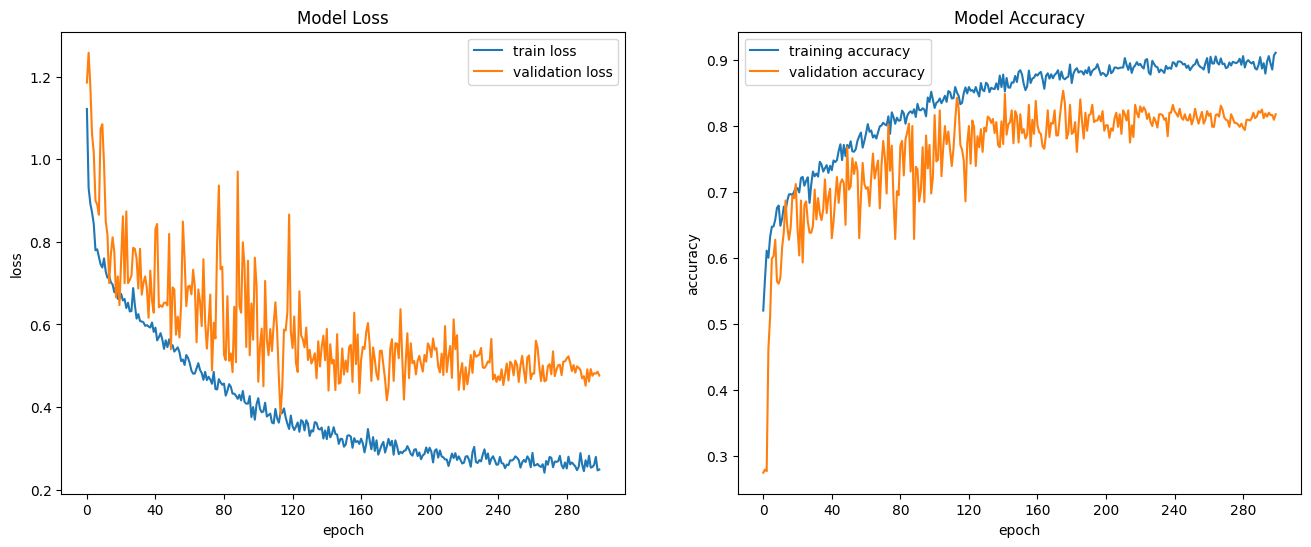

99/99 [==============================] - 5s 55ms/step - loss: 0.2487 - accuracy: 0.9103 - val_loss: 0.4762 - val_accuracy: 0.8171


In [18]:
#Train Model here

# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotLossAccuracy()

# Run the training.
model.fit(xTrain, yTrain,
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(xTest, yTest),
          callbacks=[pltCallBack], shuffle=True)

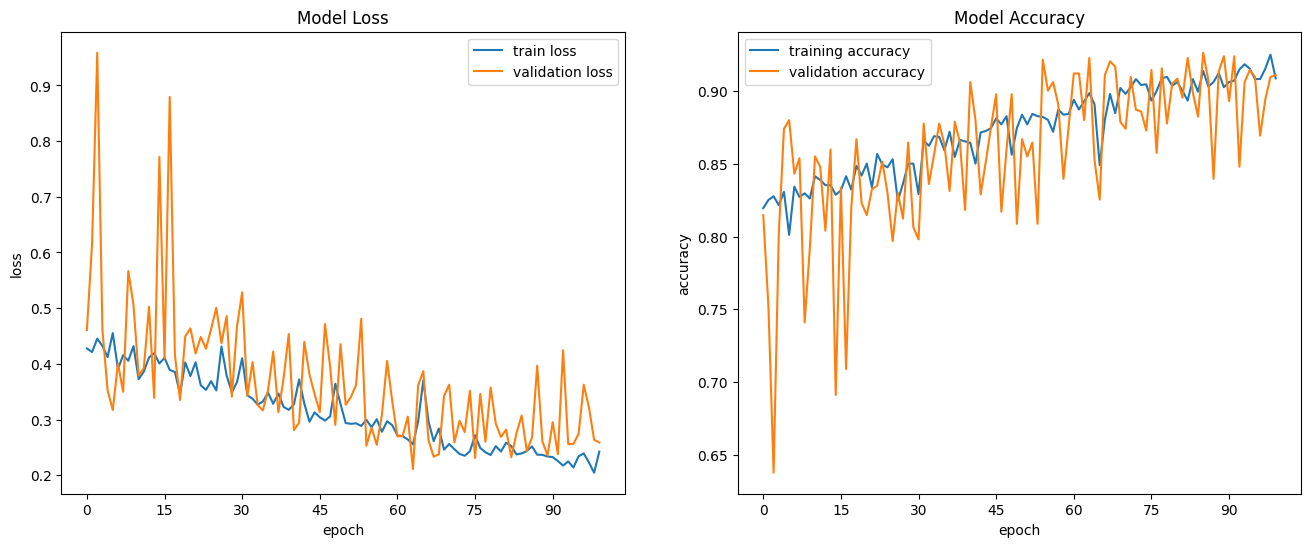

99/99 [==============================] - 13s 128ms/step - loss: 0.2425 - accuracy: 0.9088 - val_loss: 0.2589 - val_accuracy: 0.9109


In [ ]:
import json

with open('classification_model.json') as f:
  data = json.load(f)


model = keras.models.model_from_json(json.dumps(data))
model.load_weights("classification_model.h5", by_name=True)
model.summary()
pltCallBack = PlotLossAccuracy()

EPOCHS = 100
BATCH_SIZE = 20

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.ceil(xTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = lr_schedule)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Run the training.
model.fit(xTrain, yTrain,
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(xTest, yTest),
          callbacks=[pltCallBack], shuffle=True)


In [ ]:
classification_model = model
save_model_to_disk(classification_model, "classification_model")


Saved model to model.json and weights to model.h5


In [ ]:
# SEGMENTATION MODEL STARTS HERE


segXTrain, segXTest, segYTrain, segYTest = train_test_split(dInputsSeg, dOutputsSeg, test_size=0.3)

del dInputsSeg
del dOutputsSeg

In [ ]:
@tf.function
def dice_coeff(y_true, y_pred, smooth=100):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return -keras.backend.log(dice_coeff(y_true, y_pred))

In [ ]:
def attention_gate(g, s, num_filters):
    Wg = keras.layers.Conv2D(num_filters, 1, padding="same", kernel_initializer='he_normal')(g)
    Wg = keras.layers.BatchNormalization()(Wg)

    Ws = keras.layers.Conv2D(num_filters, 1, padding="same", kernel_initializer='he_normal')(s)
    Ws = keras.layers.BatchNormalization()(Ws)

    out = keras.layers.Activation("relu")(Wg+Ws)
    out = keras.layers.Conv2D(num_filters, 1, padding='same', kernel_initializer='he_normal')(out)
    out = keras.layers.Activation("sigmoid")(out)

    return out * s


In [ ]:
def conv_block(i, num_filters):
    c = keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(i)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.ReLU()(c)

    c = keras.layers.Dropout(0.1)(c)

    c = keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c)
    c = keras.layers.BatchNormalization()(c)
    c = keras.layers.ReLU()(c)

    return c


def encoder_block(i, num_filters):
    c = conv_block(i, num_filters)
    m = keras.layers.MaxPool2D(pool_size=2)(c)

    return m, c


def decoder_block(i, s, num_filters):
    x = keras.layers.UpSampling2D(interpolation='bilinear')(i)
    a = attention_gate(x, s, num_filters)
    x = keras.layers.Concatenate()([x, a])
    x = conv_block(x, num_filters)

    return x

In [ ]:
# 1st Segmentation Model


EPOCHS = 50
BATCH_SIZE = 18

#Segmentation Model. U-NET
inputs = keras.layers.Input(shape=(128, 128, 3))
c1 = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(inputs)
c1 = keras.layers.Dropout(0.1)(c1)
c2 = keras.layers.Conv2D(filters=8, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(c1)
b1 = keras.layers.BatchNormalization()(c2)
b1 = keras.layers.ReLU()(b1)
m1 = keras.layers.AveragePooling2D(pool_size=2)(b1)

c3 = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(m1)
c3 = keras.layers.Dropout(0.1)(c3)
c4 = keras.layers.Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(c3)
b2 = keras.layers.BatchNormalization()(c4)
b2 = keras.layers.ReLU()(b2)
m2 = keras.layers.AveragePooling2D(pool_size=2)(b2)

c5 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(m2)
c6 = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(c5)
b3 = keras.layers.BatchNormalization()(c6)
b3 = keras.layers.ReLU()(b3)
m3 = keras.layers.AveragePooling2D(pool_size=2)(b3)

#Bottom of the U
c7 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(m3)
b4 = keras.layers.BatchNormalization()(c7)
b4 = keras.layers.ReLU()(b4)
m4 = keras.layers.AveragePooling2D(pool_size=2)(b4)
c8 = keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer="he_normal")(m4)

#Start the Transpose convs

c9 = keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")(c8)
c9 = keras.layers.concatenate([c9, m3])
b5 = keras.layers.BatchNormalization()(c9)
b5 = keras.layers.ReLU()(b5)

c10 = keras.layers.Conv2DTranspose(filters=16, kernel_size=2, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")(b5)
c10 = keras.layers.concatenate([c10, m2])
b6 = keras.layers.BatchNormalization()(c10)
b6 = keras.layers.ReLU()(b6)

c11 = keras.layers.Conv2DTranspose(filters=8, kernel_size=2, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")(b6)
c11 = keras.layers.concatenate([c11, m1])
b7 = keras.layers.BatchNormalization()(c11)
b7 = keras.layers.ReLU()(b7)

c12 = keras.layers.Conv2DTranspose(filters=4, kernel_size=2, strides=2, padding='same', activation='relu', kernel_initializer="he_normal")(b7)
b8 = keras.layers.BatchNormalization()(c12)
b8 = keras.layers.ReLU()(b8)

seg_map = keras.layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(b8)
model = keras.models.Model(inputs=inputs, outputs=seg_map)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=np.ceil(segXTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = 1e-3)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=dice_loss,
              metrics=['accuracy'])

# Display a summary.
model.summary()


In [ ]:
#2nd Attempt at Unet. Implimenting attention gating mechanisms
EPOCHS = 100
BATCH_SIZE = 18


filterArr = [16, 24, 42, 72]

inputs = keras.layers.Input(shape=(128, 128, 3))
inputs = keras.layers.RandomBrightness((-0.4, 0.4))(inputs)
inputs = keras.layers.RandomContrast((0.8, 1.5))(inputs)


m1, s1  = encoder_block(inputs, filterArr[0]) #output sz 64

m2, s2 = encoder_block(m1, filterArr[1])      #output sz 32

m3, s3 = encoder_block(m2, filterArr[2])      #output sz 16

bottom_of_u = conv_block(m3, filterArr[3])

u1 = decoder_block(bottom_of_u, s3, filterArr[2])

u2 = decoder_block(u1, s2, filterArr[1])

u3 = decoder_block(u2, s1, filterArr[0])

seg_map = keras.layers.Conv2D(filters=1, kernel_size=1, padding='same', activation='sigmoid')(u3)
model = keras.models.Model(inputs=inputs, outputs=seg_map)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=np.ceil(segXTrain.shape[0]/BATCH_SIZE)*40,
    decay_rate=0.6)


opt = keras.optimizers.Adam(learning_rate = 1e-3)

# Setup the optimisation strategy.
model.compile(optimizer=opt,
              loss=dice_loss,
              metrics=[tf.keras.metrics.BinaryIoU(target_class_ids=[1], threshold=0.5, name='binaryIOU')])

# Display a summary.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 16)         64        ['conv2d[1][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 128, 128, 16)         0         ['batch_normalization[1][0

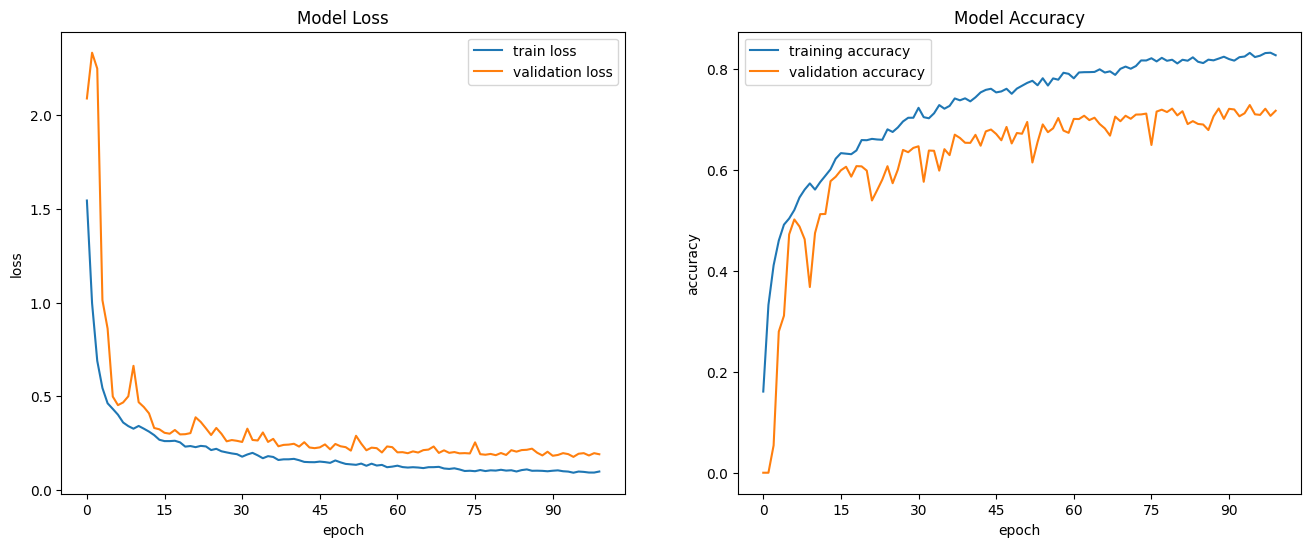

109/109 [==============================] - 10s 93ms/step - loss: 0.0988 - binaryIOU: 0.8276 - val_loss: 0.1909 - val_binaryIOU: 0.7176


In [ ]:
# Create an instance of our callback functions class, to plot our loss function and accuracy with each epoch.
pltCallBack = PlotSegLossAccuracy()

# Run the training.
model.fit(segXTrain, segYTrain,
          batch_size=BATCH_SIZE, epochs=EPOCHS,
          validation_data=(segXTest, segYTest),
          callbacks=[pltCallBack], shuffle=True)

In [ ]:
segmentation_model = model

if (segmentation_model.count_params()  < 3000000) :
  save_model_to_disk(segmentation_model, "segmentation_model")
else:
  print("Your model is unecessarily complex, scale down!")

Saved model to model.json and weights to model.h5


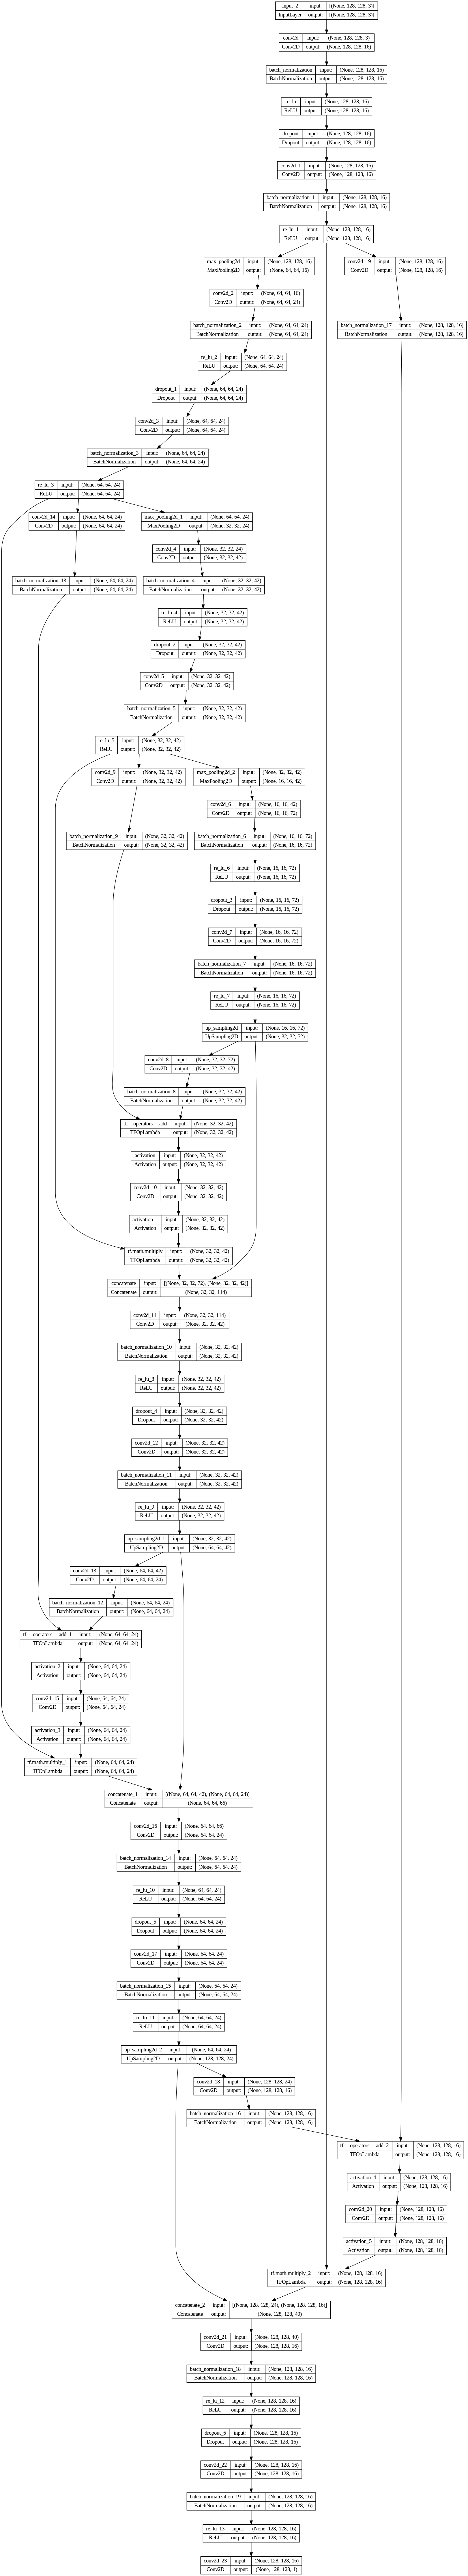

In [ ]:
tf.keras.utils.plot_model(model, to_file="SegmentationModel_With_Attention.png", show_shapes=True)

In [ ]:
from keras.models import load_model
from keras.models import model_from_json

json_file = open('segmentation_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights("segmentation_model.h5")
print("Loaded model from disk")

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

prediction = model.predict(segXTest)

Loaded model from disk
27/27 [==============================] - 2s 40ms/step


0.8357148025076714


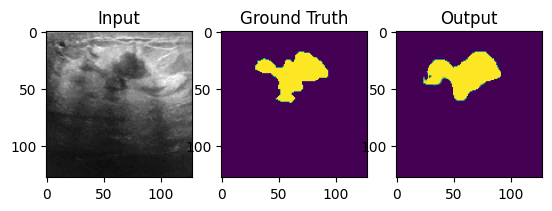

In [ ]:
SAMPLE = 5

precision = keras.metrics.Precision()

precision.update_state(segYTest, prediction)
num_precision = precision.result().numpy()

recall = keras.metrics.Recall()
recall.update_state(segYTest, prediction)
num_recall = recall.result().numpy()

print(2/((1/num_precision)+(1/num_recall)))


fig, axs = plt.subplots(1, 3)
axs[0].imshow(segXTest[SAMPLE])
axs[0].title.set_text('Input')
axs[1].imshow(segYTest[SAMPLE])
axs[1].title.set_text('Ground Truth')
axs[2].imshow(prediction[SAMPLE])
axs[2].title.set_text('Output')
plt.subplots_adjust(top=1.1)
plt.show()